#**NEURAL MATRIX FACTORIZATION**



Since the neural matrix factorization model consists of a combination of GMF and MLP, we decided to pre-train a GMF model and pre-train an MLP model. We also tried to run the NMF model without weights initializzation, but we were not satisfied by the results (the HR had never overcome 0.604 and the best NDCG was 0.343).

Given the distinct nature and internal structure of the two models, each of these two is trained on two different datasets, with different batch sizes. Subsequently, the weights are saved and initialized in the NMF model. This is then trained with the weights initialized from the pre-training of the two separate models. Pre-training and training have different parameters, such as epochs, learning rate, and dropout rate. It is possible to quickly modify these parameters directly from the parser.

During the pre-training we give the two distinct models a wide range for improvement giving zero dropout and a high learning rate. Basically in the pre-training we are exploring solutions. On the contrary, in the training we try to optimize the model in order to reach the local minimum by reducing the learning rate, increasing the dropout and the number of epochs (since we have now a smaller learning rate and the model needed more time to reach the minimum).

The learning rate dynamically decreases after each epoch, following the equation: $lr = lr_0 ⋅ γ ^ {\text{epoch}} $, where γ = 0.95

Another modification we applied to the code is regarding the activation function in the MLP model: we used the elu instead of ReLU. This was induced  by comparison of perfomance between elu, ReLU, GELU.

About the optimizer we chose to use Adam. This choice was justified by a comparison with other methods. We tried: Nadam, Adagrad, Adadelta, Adamax, AdamW, SGD, RMSprop, but Adam results to be the best one.

Finally, we set the factor number to 256.

## Setting the environment

Packages

In [ ]:
import os
import time
import random
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch.nn.init as init
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
np.random.seed(7)
torch.manual_seed(0)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_origin = {'100k': 'u.data'}

num_sample_data = '100k'
DATA_PATH = '/content/drive/MyDrive/machine learning/ML and DL/ml-100k/u.data'.format(dataset_origin[num_sample_data]) #change this with your directory
MODEL_PATH = '/content/drive/MyDrive/machine learning/ML and DL/ml-100k'.format(num_sample_data) #change this with your directory

ml_100k = pd.read_csv(
	DATA_PATH,
	sep="\t",
	names = ['user_id', 'item_id', 'rating', 'timestamp'],
	engine='python')

**Datasets**.
We defined 3 different datasets, varying on the batch size only:


*   NMF_Data: dataset for NMF training, batch size = 1024
*   MLP_Data: dataset for MLP pre-training, batch size = 256
*   GMF_Data: dataset for GMF pre-training, batch size = 1024



In [ ]:
class Rating_Datset(Dataset):
	def __init__(self, user_list, item_list, rating_list):
		super(Rating_Datset, self).__init__() # to use superior class (Dataset) functions
		self.user_list = user_list
		self.item_list = item_list
		self.rating_list = rating_list

	def __len__(self):
		return len(self.user_list)

	def __getitem__(self, idx):
		user = self.user_list[idx]
		item = self.item_list[idx]
		rating = self.rating_list[idx]

		return (
			torch.tensor(user, dtype=torch.long),
			torch.tensor(item, dtype=torch.long),
			torch.tensor(rating, dtype=torch.float)
			)

class NMF_Data(object):
	"""
	Construct Dataset for NMF TRAIN
	"""
	def __init__(self, args, ratings): # takes dataset
		self.ratings = ratings
		self.num_ng = args.num_ng # ng = negative samples
		self.num_ng_test = args.num_ng_test
		self.batch_size = args.batch_size_NMF

		self.preprocess_ratings = self._reindex(self.ratings) # re-index users, items and adapts ratings as binary

		self.user_pool = set(self.ratings['user_id'].unique()) # all the diff users
		self.item_pool = set(self.ratings['item_id'].unique()) # all the diff item

		self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings) # train and test ratings
		self.negatives = self._negative_sampling(self.preprocess_ratings) # list of ng, to have items not interacted with users and make training

	def _reindex(self, ratings):
		"""
		Process dataset to reindex userID and itemID, also set rating as binary feedback
		"""
		user_list = list(ratings['user_id'].drop_duplicates())
		user2id = {w: i for i, w in enumerate(user_list)} # dictionary of users

		item_list = list(ratings['item_id'].drop_duplicates())
		item2id = {w: i for i, w in enumerate(item_list)} # dictionary of items

		ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
		ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
		ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
		return ratings

	def _leave_one_out(self, ratings):
		"""
		leave-one-out evaluation protocol in paper https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf
		"""
		ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
		test = ratings.loc[ratings['rank_latest'] == 1]
		train = ratings.loc[ratings['rank_latest'] > 1]
		assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
		return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]

	def _negative_sampling(self, ratings):
		interact_status = (
			ratings.groupby('user_id')['item_id']
			.apply(set)
			.reset_index()
			.rename(columns={'item_id': 'interacted_items'}))
		interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
		interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
		return interact_status[['user_id', 'negative_items', 'negative_samples']]

	def get_train_instance(self):
		users, items, ratings = [], [], []
		train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
		train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
		for row in train_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in range(self.num_ng):
				users.append(int(row.user_id))
				items.append(int(row.negatives[i]))
				ratings.append(float(0))  # negative samples get 0 rating

		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

	def get_test_instance(self):
		users, items, ratings = [], [], []
		test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
		for row in test_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in getattr(row, 'negative_samples'):
				users.append(int(row.user_id))
				items.append(int(i))
				ratings.append(float(0))
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=2)

class MLP_Data(object):
	"""
	Construct Dataset for MLP PRE-TRAIN
	"""
	def __init__(self, args, ratings): # takes dataset
		self.ratings = ratings
		self.num_ng = args.num_ng # ng = negative samples
		self.num_ng_test = args.num_ng_test
		self.batch_size = args.batch_size_MLP

		self.preprocess_ratings = self._reindex(self.ratings) # re-index users, items and adapts ratings as binary

		self.user_pool = set(self.ratings['user_id'].unique()) # all the diff users
		self.item_pool = set(self.ratings['item_id'].unique()) # all the diff item

		self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings) # train and test ratings
		self.negatives = self._negative_sampling(self.preprocess_ratings) # list of ng, to have items not interacted with users and make training

	def _reindex(self, ratings):
		"""
		Process dataset to reindex userID and itemID, also set rating as binary feedback
		"""
		user_list = list(ratings['user_id'].drop_duplicates())
		user2id = {w: i for i, w in enumerate(user_list)} # dictionary of users

		item_list = list(ratings['item_id'].drop_duplicates())
		item2id = {w: i for i, w in enumerate(item_list)} # dictionary of items

		ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
		ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
		ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
		return ratings

	def _leave_one_out(self, ratings):
		"""
		leave-one-out evaluation protocol in paper https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf
		"""
		ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
		test = ratings.loc[ratings['rank_latest'] == 1]
		train = ratings.loc[ratings['rank_latest'] > 1]
		assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
		return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]

	def _negative_sampling(self, ratings):
		interact_status = (
			ratings.groupby('user_id')['item_id']
			.apply(set)
			.reset_index()
			.rename(columns={'item_id': 'interacted_items'}))
		interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
		interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
		return interact_status[['user_id', 'negative_items', 'negative_samples']]

	def get_train_instance(self):
		users, items, ratings = [], [], []
		train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
		train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
		for row in train_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in range(self.num_ng):
				users.append(int(row.user_id))
				items.append(int(row.negatives[i]))
				ratings.append(float(0))  # negative samples get 0 rating

		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

	def get_test_instance(self):
		users, items, ratings = [], [], []
		test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
		for row in test_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in getattr(row, 'negative_samples'):
				users.append(int(row.user_id))
				items.append(int(i))
				ratings.append(float(0))
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=2)

class GMF_Data(object):
	"""
	Construct Dataset for GMF PRE-TRAIN
	"""
	def __init__(self, args, ratings): # takes dataset
		self.ratings = ratings
		self.num_ng = args.num_ng # ng = negative samples
		self.num_ng_test = args.num_ng_test
		self.batch_size = args.batch_size_GMF

		self.preprocess_ratings = self._reindex(self.ratings) # re-index users, items and adapts ratings as binary

		self.user_pool = set(self.ratings['user_id'].unique()) # all the diff users
		self.item_pool = set(self.ratings['item_id'].unique()) # all the diff item

		self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings) # train and test ratings
		self.negatives = self._negative_sampling(self.preprocess_ratings) # list of ng, to have items not interacted with users and make training

	def _reindex(self, ratings):
		"""
		Process dataset to reindex userID and itemID, also set rating as binary feedback
		"""
		user_list = list(ratings['user_id'].drop_duplicates())
		user2id = {w: i for i, w in enumerate(user_list)} # dictionary of users

		item_list = list(ratings['item_id'].drop_duplicates())
		item2id = {w: i for i, w in enumerate(item_list)} # dictionary of items

		ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
		ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
		ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
		return ratings

	def _leave_one_out(self, ratings):
		"""
		leave-one-out evaluation protocol in paper https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf
		"""
		ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
		test = ratings.loc[ratings['rank_latest'] == 1]
		train = ratings.loc[ratings['rank_latest'] > 1]
		assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
		return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]

	def _negative_sampling(self, ratings):
		interact_status = (
			ratings.groupby('user_id')['item_id']
			.apply(set)
			.reset_index()
			.rename(columns={'item_id': 'interacted_items'}))
		interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
		interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
		return interact_status[['user_id', 'negative_items', 'negative_samples']]

	def get_train_instance(self):
		users, items, ratings = [], [], []
		train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
		train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
		for row in train_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in range(self.num_ng):
				users.append(int(row.user_id))
				items.append(int(row.negatives[i]))
				ratings.append(float(0))  # negative samples get 0 rating

		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

	def get_test_instance(self):
		users, items, ratings = [], [], []
		test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
		for row in test_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in getattr(row, 'negative_samples'):
				users.append(int(row.user_id))
				items.append(int(i))
				ratings.append(float(0))
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=2)

Evaluation Metrics

In [ ]:
def hit(ng_item, pred_items):
	if ng_item in pred_items:
		return 1
	return 0


def ndcg(ng_item, pred_items):
	if ng_item in pred_items:
		index = pred_items.index(ng_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def metrics(model, test_loader, top_k, device):
	HR, NDCG = [], []

	for user, item, label in test_loader:
		user = user.to(device)
		item = item.to(device)

		predictions = model(user, item)
		_, indices = torch.topk(predictions, top_k)
		recommends = torch.take(
				item, indices).cpu().numpy().tolist()

		ng_item = item[0].item() # leave one-out evaluation has only one item per user
		HR.append(hit(ng_item, recommends))
		NDCG.append(ndcg(ng_item, recommends))

	return np.mean(HR), np.mean(NDCG)

## Parser

In [ ]:
#collapse-hide
parser = argparse.ArgumentParser()
parser.add_argument("--seed",
	type=int,
	default=42,
	help="Seed")
parser.add_argument("--lr_pre_training",
	type=float,
	default=0.001,
	help="pre-training learning rate")
parser.add_argument("--lr",
	type=float,
	default=0.00025,
	help="learning rate")
parser.add_argument("--dropout_pre_training",
	type=float,
	default=0,
	help="pre-training dropout rate")
parser.add_argument("--dropout",
	type=float,
	default=0.5,
	help="dropout rate")
parser.add_argument("--batch_size_MLP",
	type=int,
	default=256,
	help="batch size for MLP pre-training")
parser.add_argument("--batch_size_GMF",
	type=int,
	default=1024,
	help="batch size for GMF pre-training")
parser.add_argument("--batch_size_NMF",
	type=int,
	default=1024,
	help="batch size for training")
parser.add_argument("--epochs_pre_training",
	type=int,
	default=15,
	help="pre-training epoches")
parser.add_argument("--epochs",
	type=int,
	default=20,
	help="training epoches")
parser.add_argument("--top_k",
	type=int,
	default=10,
	help="compute metrics@top_k")
parser.add_argument("--factor_num",
	type=int,
	default=256,
	help="predictive factors numbers in the model")
parser.add_argument("--layers",
    nargs='+',
    default=[512,64,256,32], #[args.factor_num * 2, int(args.factor_num / 4), args.factor_num, int(args.factor_num / 8)]
    help="MLP layers. Note that the first layer is the concatenation of user \
    and item embeddings. So layers[0]/2 is the embedding size.")
parser.add_argument("--num_ng",
	type=int,
	default=4,
	help="Number of negative samples for training set")
parser.add_argument("--num_ng_test",
	type=int,
	default=100,
	help="Number of negative samples for test set")
parser.add_argument("--out",
	default=True,
	help="save model or not")

_StoreAction(option_strings=['--out'], dest='out', nargs=None, const=None, default=True, type=None, choices=None, required=False, help='save model or not', metavar=None)

## Pre-training

### Definition of models

In [ ]:
class GMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)
        init.xavier_normal_(self.embedding_user.weight)
        init.xavier_normal_(self.embedding_item.weight)

        self.affine_output = nn.Linear(in_features=self.factor_num, out_features=1)
        init.xavier_normal_(self.affine_output.weight)

        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating.squeeze()

class MLP(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num # num of neurons in hidden layers
        self.layers = args.layers

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        for layer in self.fc_layers:
            init.xavier_normal_(layer.weight)

        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        init.xavier_normal_(self.affine_output.weight)

        self.logistic = nn.Sigmoid()


    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)

        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating.squeeze()


### GMF PRE-TRAIN

Since the GMF structure is pretty simple, we chose a batch size of 1024 in order to let the model acquire as much information as possible before updating the weights. We think that the combination of a simple model and a small batch size would lead to a non-robust update of the weights.

In [ ]:
# set device and parameters
args = parser.parse_args("")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load data
ml_100k = pd.read_csv(
	DATA_PATH,
	sep="\t",
	names = ['user_id', 'item_id', 'rating', 'timestamp'],
	engine='python')

# set the num_users, items
num_users = ml_100k['user_id'].nunique()+1
num_items = ml_100k['item_id'].nunique()+1

# construct the train and test datasets
data = GMF_Data(args, ml_100k)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

# set model and loss, optimizer
model = GMF(args, num_users, num_items)
model = model.to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr_pre_training)

scheduler = ExponentialLR(optimizer=optimizer, gamma=0.95)

# train, evaluation
best_hr = 0
for epoch in range(1, args.epochs_pre_training+1):
	model.train() # Enable dropout (if have).
	start_time = time.time()

	for user, item, label in train_loader:
		user = user.to(device)
		item = item.to(device)
		label = label.to(device)

		optimizer.zero_grad()
		prediction = model(user, item)
		loss = loss_function(prediction, label)
		loss.backward()
		optimizer.step()

	scheduler.step()

	model.eval()
	HR, NDCG = metrics(model, test_loader, args.top_k, device)

	elapsed_time = time.time() - start_time
	print("Epoch {:03d}".format(epoch) + " time to train: " +
			time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
	print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

	if HR > best_hr:
		best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
		if args.out:
			if not os.path.exists(MODEL_PATH):
				os.mkdir(MODEL_PATH)
			torch.save(model.state_dict(),
				'{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))

<ipython-input-4-f29b1bdc6fb8>:250: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
<ipython-input-4-f29b1bdc6fb8>:256: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warn

Epoch 001 time to train: 00: 00: 21
HR: 0.398	NDCG: 0.216
Epoch 002 time to train: 00: 00: 22
HR: 0.568	NDCG: 0.318
Epoch 003 time to train: 00: 00: 21
HR: 0.626	NDCG: 0.351
Epoch 004 time to train: 00: 00: 23
HR: 0.657	NDCG: 0.371
Epoch 005 time to train: 00: 00: 23
HR: 0.667	NDCG: 0.384
Epoch 006 time to train: 00: 00: 21
HR: 0.665	NDCG: 0.386
Epoch 007 time to train: 00: 00: 22
HR: 0.673	NDCG: 0.389
Epoch 008 time to train: 00: 00: 21
HR: 0.670	NDCG: 0.390
Epoch 009 time to train: 00: 00: 22
HR: 0.681	NDCG: 0.394
Epoch 010 time to train: 00: 00: 21
HR: 0.679	NDCG: 0.393
Epoch 011 time to train: 00: 00: 22
HR: 0.682	NDCG: 0.394
Epoch 012 time to train: 00: 00: 21
HR: 0.674	NDCG: 0.392
Epoch 013 time to train: 00: 00: 22
HR: 0.679	NDCG: 0.395
Epoch 014 time to train: 00: 00: 20
HR: 0.680	NDCG: 0.393
Epoch 015 time to train: 00: 00: 22
HR: 0.679	NDCG: 0.392


### MLP PRE-TRAIN

Regarding the MLP structure, we opted to use an autoencoder-based layer configuration: [512, 64, 256, 32]. This was the result of about 50 different runs with 50 different configurations.

For what concerns the batch size choiche, we started with the same value of the GMF model (1024). However we experimentally noticed that reducing the batch size increased the overall score and performance. A possible explanation is that the MLP is a much more complex model and can capture more information. So it's better to update more frequently the weights during an epoch (taking into account the higher number of parameters).

In [ ]:
# set device and parameters
args = parser.parse_args("")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# load data
ml_100k = pd.read_csv(
	DATA_PATH,
	sep="\t",
	names = ['user_id', 'item_id', 'rating', 'timestamp'],
	engine='python')

# set the num_users, items
num_users = ml_100k['user_id'].nunique()+1
num_items = ml_100k['item_id'].nunique()+1

# construct the train and test datasets
data = MLP_Data(args, ml_100k)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

# set model and loss, optimizer
model = MLP(args, num_users, num_items)
model = model.to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr_pre_training)
scheduler = ExponentialLR(optimizer=optimizer, gamma=0.95)

# train, evaluation
best_hr = 0
for epoch in range(1, args.epochs_pre_training+1):
	model.train()
	start_time = time.time()

	for user, item, label in train_loader:
		user = user.to(device)
		item = item.to(device)
		label = label.to(device)

		optimizer.zero_grad()
		prediction = model(user, item)
		loss = loss_function(prediction, label)
		loss.backward()
		optimizer.step()

	scheduler.step()

	model.eval()
	HR, NDCG = metrics(model, test_loader, args.top_k, device)

	elapsed_time = time.time() - start_time
	print("Epoch {:03d}".format(epoch) + " time to train: " +
			time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
	print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

	if HR > best_hr:
		best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
		if args.out:
			if not os.path.exists(MODEL_PATH):
				os.mkdir(MODEL_PATH)
			torch.save(model.state_dict(),
				'{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))


<ipython-input-4-f29b1bdc6fb8>:161: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
<ipython-input-4-f29b1bdc6fb8>:167: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warn

Epoch 001 time to train: 00: 00: 36
HR: 0.397	NDCG: 0.217
Epoch 002 time to train: 00: 00: 34
HR: 0.450	NDCG: 0.246
Epoch 003 time to train: 00: 00: 36
HR: 0.516	NDCG: 0.290
Epoch 004 time to train: 00: 00: 34
HR: 0.544	NDCG: 0.307
Epoch 005 time to train: 00: 00: 36
HR: 0.563	NDCG: 0.323
Epoch 006 time to train: 00: 00: 43
HR: 0.568	NDCG: 0.324
Epoch 007 time to train: 00: 00: 37
HR: 0.568	NDCG: 0.329
Epoch 008 time to train: 00: 00: 37
HR: 0.572	NDCG: 0.327
Epoch 009 time to train: 00: 00: 37
HR: 0.565	NDCG: 0.324
Epoch 010 time to train: 00: 00: 35
HR: 0.562	NDCG: 0.314
Epoch 011 time to train: 00: 00: 37
HR: 0.561	NDCG: 0.318
Epoch 012 time to train: 00: 00: 36
HR: 0.561	NDCG: 0.317
Epoch 013 time to train: 00: 00: 36
HR: 0.561	NDCG: 0.315
Epoch 014 time to train: 00: 00: 37
HR: 0.564	NDCG: 0.316
Epoch 015 time to train: 00: 00: 35
HR: 0.562	NDCG: 0.309


## Models for Neural Matrix Factorization

We built the model as suggested by the excercise. The main difference is the initialization of the weights we added.

In [ ]:
class GMF_NMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(GMF_NMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.affine_output = nn.Linear(in_features=self.factor_num, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)

        return element_product

class MLP_NMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(MLP_NMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num
        self.layers = args.layers


        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.fc_layers = nn.ModuleList()
        for i in range(len(self.layers) - 1): #idx, (in_size, out_size) in enumerate(zip(self.layers_MLP[:-1], self.layers_MLP[1:])):
            self.fc_layers.append(nn.Linear(self.layers[i], self.layers[i+1]))


        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = F.elu(vector)

            vector = nn.Dropout(p=args.dropout)(vector)

        return vector

class NeuMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(NeuMF, self).__init__()

        self.GMFModel = GMF_NMF(args, num_users, num_items)
        self.MLPModel = MLP_NMF(args, num_users, num_items)

        self.GMFModel.load_state_dict(torch.load("/content/drive/MyDrive/machine learning/ML and DL/ml-100kGMF.pt", map_location=torch.device('cpu')))
        self.MLPModel.load_state_dict(torch.load("/content/drive/MyDrive/machine learning/ML and DL/ml-100kMLP.pt", map_location=torch.device('cpu')))

        self.affine_output = nn.Linear(in_features=32+256, out_features=1) #last mlp layer + fac number


        self.logistic = nn.Sigmoid()


    def forward(self, user_indices, item_indices):

        # MLP PART

        MLP_res = self.MLPModel(user_indices, item_indices)

        # MF PART

        GMF_res = self.GMFModel(user_indices, item_indices)

        # Concatenation

        result = torch.cat([MLP_res, GMF_res], dim=-1)
        result = self.affine_output(result)

        result = self.logistic(result)

        return result.squeeze()


In [ ]:
def plot_loss(hr, ndcg):
  plt.plot(range(len(hr)), hr, c='b', label='Hit Rate')
  plt.plot(range(len(ndcg)), ndcg, c='r', label='Normalized Discrete Cognitive Geometrical')
  plt.xlabel('Epoch')
  plt.ylabel('Score')
  plt.title('HR and NDCG Evolution')
  plt.legend()
  plt.show()

NEURAL MATRIX FACTORIZATION TRAIN

<ipython-input-4-f29b1bdc6fb8>:72: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
<ipython-input-4-f29b1bdc6fb8>:78: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warnin

Epoch 001 time to train: 00: 00: 28
HR: 0.461	NDCG: 0.250
Epoch 002 time to train: 00: 00: 28
HR: 0.548	NDCG: 0.320
Epoch 003 time to train: 00: 00: 28
HR: 0.593	NDCG: 0.346
Epoch 004 time to train: 00: 00: 28
HR: 0.624	NDCG: 0.366
Epoch 005 time to train: 00: 00: 28
HR: 0.648	NDCG: 0.378
Epoch 006 time to train: 00: 00: 28
HR: 0.670	NDCG: 0.392
Epoch 007 time to train: 00: 00: 28
HR: 0.674	NDCG: 0.396
Epoch 008 time to train: 00: 00: 28
HR: 0.689	NDCG: 0.401
Epoch 009 time to train: 00: 00: 33
HR: 0.687	NDCG: 0.404
Epoch 010 time to train: 00: 00: 28
HR: 0.690	NDCG: 0.409
Epoch 011 time to train: 00: 00: 28
HR: 0.691	NDCG: 0.407
Epoch 012 time to train: 00: 00: 28
HR: 0.699	NDCG: 0.411
Epoch 013 time to train: 00: 00: 28
HR: 0.695	NDCG: 0.412
Epoch 014 time to train: 00: 00: 28
HR: 0.691	NDCG: 0.414
Epoch 015 time to train: 00: 00: 29
HR: 0.701	NDCG: 0.415
Epoch 016 time to train: 00: 00: 29
HR: 0.706	NDCG: 0.416
Epoch 017 time to train: 00: 00: 28
HR: 0.698	NDCG: 0.416
Epoch 018 time

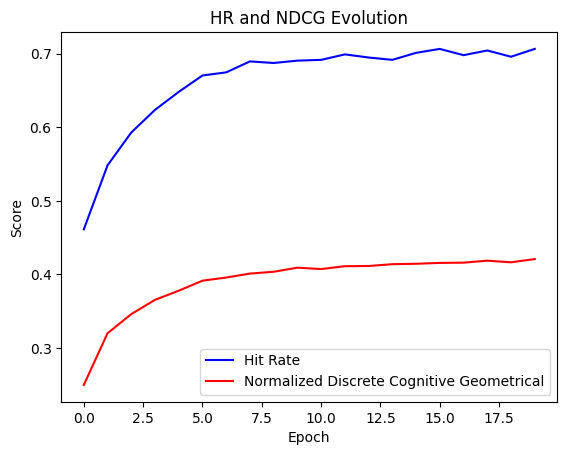

In [ ]:
# set device and parameters
args = parser.parse_args("")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load data
ml_100k = pd.read_csv(
	DATA_PATH,
	sep="\t",
	names = ['user_id', 'item_id', 'rating', 'timestamp'],
	engine='python')

# set the num_users, items
num_users = ml_100k['user_id'].nunique()+1
num_items = ml_100k['item_id'].nunique()+1

# construct the train and test datasets
data = NMF_Data(args, ml_100k)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

# set model and loss, optimizer
model = NeuMF(args, num_users, num_items)
model = model.to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = ExponentialLR(optimizer=optimizer, gamma=0.95)

# train, evaluation
best_hr = 0
hr_evolution = []
ndcg_evolution = []

for epoch in range(1, args.epochs+1):
	model.train()
	start_time = time.time()

	for user, item, label in train_loader:
		user = user.to(device)
		item = item.to(device)
		label = label.to(device)

		optimizer.zero_grad()
		prediction = model(user, item)
		loss = loss_function(prediction, label)
		loss.backward()
		optimizer.step()

	scheduler.step()
	model.eval()
	HR, NDCG = metrics(model, test_loader, args.top_k, device)

	elapsed_time = time.time() - start_time
	print("Epoch {:03d}".format(epoch) + " time to train: " +
			time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
	print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

	hr_evolution.append(HR)
	ndcg_evolution.append(NDCG)

	if HR > best_hr:
		best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
		if args.out:
			if not os.path.exists(MODEL_PATH):
				os.mkdir(MODEL_PATH)
			torch.save(model,
				'{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))

plot_loss(hr_evolution, ndcg_evolution)

## Plotting

Let's plot

In [ ]:
import h5py

We changed the factor number (8, 16, 32, 64), runned the code and then saved the HR and NDCG evolution for each run

By doing so, we kept the structure of the MLP "fixed", by using:

[N ⋅ 2, N / 4, N, N / 8] as layers structure, where N = factor number.

For the GMF and NMF, other modifications were not needed.

In [ ]:
with h5py.File('/content/drive/MyDrive/machine learning/ML and DL/@10new/facn8.csv', "w") as facn8:
  facn8.create_dataset('hr_evolution_8', data=hr_evolution)
  facn8.create_dataset('ndcg_evolution_8', data=ndcg_evolution)

In [ ]:
with h5py.File('/content/drive/MyDrive/machine learning/ML and DL/@10new/facn16.csv', "w") as facn16:
  facn16.create_dataset('hr_evolution_16', data=hr_evolution)
  facn16.create_dataset('ndcg_evolution_16', data=ndcg_evolution)

In [ ]:
with h5py.File('/content/drive/MyDrive/machine learning/ML and DL/@10new/facn32.csv', "w") as facn32:
  facn32.create_dataset('hr_evolution_32', data=hr_evolution)
  facn32.create_dataset('ndcg_evolution_32', data=ndcg_evolution)

In [ ]:
with h5py.File('/content/drive/MyDrive/machine learning/ML and DL/@10new/facn64.csv', "w") as facn64:
  facn64.create_dataset('hr_evolution_64', data=hr_evolution)
  facn64.create_dataset('ndcg_evolution_64', data=ndcg_evolution)

HR Evolution

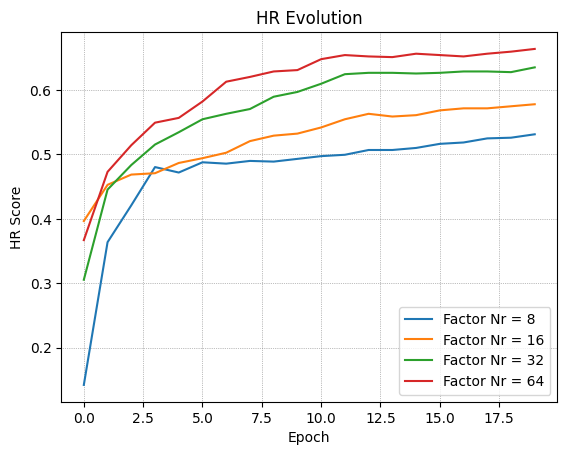

In [ ]:
# Open the file
with h5py.File('/content/drive/MyDrive/machine learning/ML and DL/@10new/facn8.csv', "r") as facn8:
    # Load the data
    hr_evolution8 = facn8['hr_evolution_8'][:]

with h5py.File('/content/drive/MyDrive/machine learning/ML and DL/@10new/facn16.csv', "r") as facn16:
    # Load the data
    hr_evolution16 = facn16['hr_evolution_16'][:]

with h5py.File('/content/drive/MyDrive/machine learning/ML and DL/@10new/facn32.csv', "r") as facn32:
    # Load the data
    hr_evolution32 = facn32['hr_evolution_32'][:]

with h5py.File('/content/drive/MyDrive/machine learning/ML and DL/@10new/facn64.csv', "r") as facn64:
    # Load the data
    hr_evolution64 = facn64['hr_evolution_64'][:]


# Plot
plt.plot(hr_evolution8, label='Factor Nr = 8')
plt.plot(hr_evolution16, label='Factor Nr = 16')
plt.plot(hr_evolution32, label='Factor Nr = 32')
plt.plot(hr_evolution64, label='Factor Nr = 64')
plt.xlabel('Epoch')
plt.ylabel('HR Score')
plt.title('HR Evolution')
plt.legend()
plt.grid(True, linestyle='dotted', linewidth=0.5, color='gray')
plt.show()


NDCG Evolution

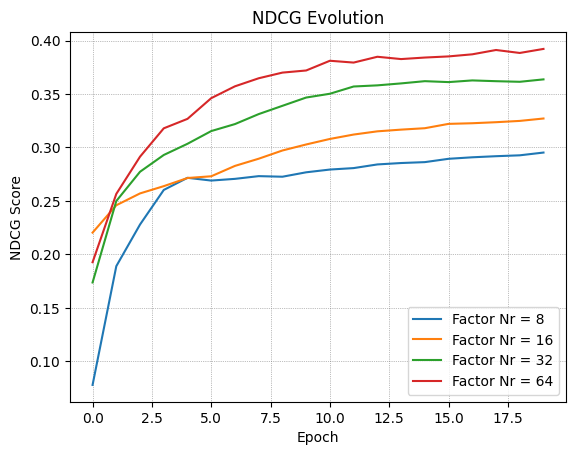

In [ ]:
with h5py.File('/content/drive/MyDrive/machine learning/ML and DL/@10new/facn8.csv', "r") as facn8:
    # Load the data
    ndcg_evolution_8 = facn8['ndcg_evolution_8'][:]

with h5py.File('/content/drive/MyDrive/machine learning/ML and DL/@10new/facn16.csv', "r") as facn16:
    # Load the data
    ndcg_evolution_16 = facn16['ndcg_evolution_16'][:]

with h5py.File('/content/drive/MyDrive/machine learning/ML and DL/@10new/facn32.csv', "r") as facn32:
    # Load the data
    ndcg_evolution_32 = facn32['ndcg_evolution_32'][:]

with h5py.File('/content/drive/MyDrive/machine learning/ML and DL/@10new/facn64.csv', "r") as facn64:
    # Load the data
    ndcg_evolution_64 = facn64['ndcg_evolution_64'][:]


# Plot
plt.plot(ndcg_evolution_8, label='Factor Nr = 8')
plt.plot(ndcg_evolution_16, label='Factor Nr = 16')
plt.plot(ndcg_evolution_32, label='Factor Nr = 32')
plt.plot(ndcg_evolution_64, label='Factor Nr = 64')
plt.xlabel('Epoch')
plt.ylabel('NDCG Score')
plt.title('NDCG Evolution')
plt.grid(True, linestyle='dotted', linewidth=0.5, color='gray')
plt.legend()
plt.show()


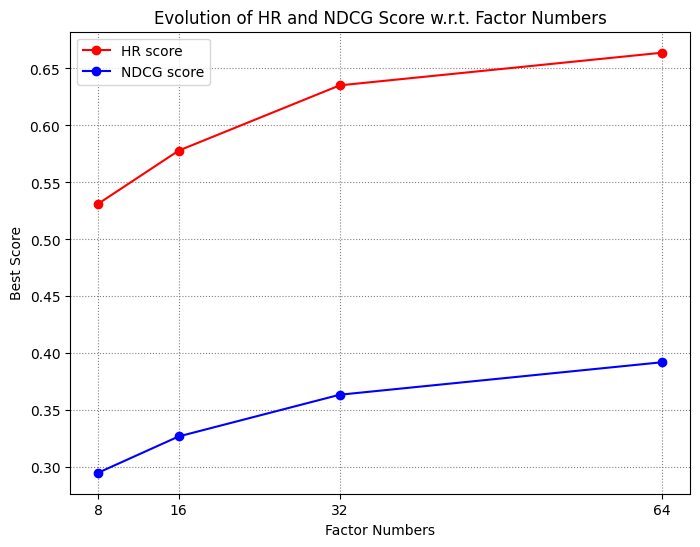

In [ ]:
# Extract the best value for each factor number
best_hr_scores = [hr_evolution8[-1], hr_evolution16[-1], hr_evolution32[-1], hr_evolution64[-1]]
best_ndgc_scores = [ndcg_evolution_8[-1], ndcg_evolution_16[-1], ndcg_evolution_32[-1], ndcg_evolution_64[-1]]

factor_numbers = [8, 16, 32, 64]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(factor_numbers, best_hr_scores, marker='o', linestyle='-', color='r', label='HR score')
plt.plot(factor_numbers, best_ndgc_scores, marker='o', linestyle='-', color='b', label='NDCG score')
plt.title('Evolution of HR and NDCG Score w.r.t. Factor Numbers')
plt.xlabel('Factor Numbers')
plt.ylabel('Best Score')
plt.legend()
plt.xticks(factor_numbers)
plt.grid(True, linestyle='dotted', linewidth=0.8, color='gray')
plt.show()

Looking at the different plots, it's evident that the bigger the factor number, the better the score. That's why we run our model with a factor number even bigger (256), reaching a maximum score for HR of 0.706 and for NDCG of 0.421